# SNN Playground


In [54]:
import sys
import snntorch as snn
from snntorch import spikeplot as split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Module
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import rsatoolbox as rsa
from rsatoolbox.inference import evaluate as eval
from rsatoolbox.inference.bootstrap import (bootstrap_sample,
                                            bootstrap_sample_pattern,
                                            bootstrap_sample_rdm)
from rsatoolbox.util.inference_util import all_tests, get_errorbars
from rsatoolbox.util.rdm_utils import batch_to_vectors
from rsatoolbox.util.inference_util import all_tests, get_errorbars
from rsatoolbox.util.rdm_utils import batch_to_vectors
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print("env path: ", sys.executable) 

#[+] check to see if gpu is available, else use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ',device)
for i in range(torch.cuda.device_count()): print('       -->',i,':', torch.cuda.get_device_name(i))

System Version: 3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]
PyTorch version 2.3.1+cu118
Numpy version 1.26.4
env path:  c:\Users\richa\OneDrive\Dugree\Project\cuda\Scripts\python.exe
Using device:  cuda
       --> 0 : NVIDIA GeForce RTX 2070


## Helper Fx

#### From W1D3 Tutorial2

In [25]:
def get_sample_images_ordered(test_loader, n_samples=100, samples_per_class=None):

    # structure as:
    # class 1 sample 1, class 1 sample 2, ...
    # class 2 sample 1, ...
    # ...
    # class 10 sample 1, ...

    # For MNIST, we have 10 classes (0-9)
    num_classes = 10

    # Calculate samples per class
    if samples_per_class is None:
        samples_per_class = n_samples // num_classes

    # Adjust total samples to ensure even distribution
    actual_n_samples = samples_per_class * num_classes

    print(f"Collecting {samples_per_class} samples per class ({actual_n_samples} total)")

    # Collect images by class
    class_images = {i: [] for i in range(num_classes)}
    class_labels = {i: [] for i in range(num_classes)}

    # Collect images from dataloader
    for batch_imgs, batch_labels in test_loader:
        for img, label in zip(batch_imgs, batch_labels):
            label_int = label.item()

            # Only collect if we haven't reached the limit for this class
            if len(class_images[label_int]) < samples_per_class:
                class_images[label_int].append(img.unsqueeze(0))
                class_labels[label_int].append(label.unsqueeze(0))

        # Check if we have enough samples for all classes
        if all(len(class_images[i]) >= samples_per_class for i in range(num_classes)):
            break


    ordered_imgs = []
    ordered_labels = []

    for class_idx in range(num_classes):
        # Take exactly samples_per_class for each class
        class_imgs = class_images[class_idx][:samples_per_class]
        class_lbls = class_labels[class_idx][:samples_per_class]

        ordered_imgs.extend(class_imgs)
        ordered_labels.extend(class_lbls)


    final_imgs = torch.cat(ordered_imgs)
    final_labels = torch.cat(ordered_labels)


    return final_imgs, final_labels

def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation' is pearson, 'euclidean', 'spearman', 'cosine'

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]


        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def plot_rdms(rdms_dict, figsize_per_plot=(3.5, 3), cmap='viridis'):
    """
    Plot RDMs for visualization

    Args:
        rdms_dict: Dictionary of RDMs by layer name
        figsize_per_plot: Size of each subplot
        cmap: Colormap for visualization

    revise so all subplots share the same color scale (legend range) based on the global min and max across all RDMs
    """

    n_layers = len(rdms_dict)
    cols = min(3, n_layers)  # Max 3 columns
    rows = (n_layers + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols,
                            figsize=(cols * figsize_per_plot[0], rows * figsize_per_plot[1]))

    if n_layers == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()

    # Compute global vmin and vmax across all RDMs
    all_values = np.concatenate([rdm.flatten() for rdm in rdms_dict.values()])
    vmin, vmax = all_values.min(), all_values.max()

    for idx, (layer_name, rdm) in enumerate(rdms_dict.items()):
        ax = axes[idx]

        # Plot RDM
        im = ax.imshow(rdm, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
        ax.set_title(f'{layer_name}\n({rdm.shape[0]}×{rdm.shape[1]})')
        ax.set_xlabel('Stimulus')
        ax.set_ylabel('Stimulus')

        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)

    # Hide empty subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Representational Dissimilarity Matrices (RDMs)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()

def compute_label_rdm_correlation(labels):
    """
    Compute a correlation-distance RDM from one-hot encoded labels.
    Equivalent to how feature RDMs are calculated.

    Args:
        labels (torch.Tensor or np.ndarray): Class labels (N,)

    Returns:
        label_rdm (np.ndarray): RDM of shape (N, N)
    """
    labels_np = labels.cpu().numpy() if torch.is_tensor(labels) else labels
    labels_np = labels_np.reshape(-1, 1)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    labels_onehot = encoder.fit_transform(labels_np)

    # Compute Pearson correlation distance: 1 - r
    label_rdm = squareform(pdist(labels_onehot, metric='correlation'))
    return label_rdm

def plot_label_rdm(label_rdm, title='Label RDM (Correlation Distance)', figsize=(6, 5), cmap='viridis'):
    plt.figure(figsize=figsize)
    plt.imshow(label_rdm, cmap=cmap, aspect='auto')
    plt.title(title)
    plt.xlabel('Stimulus')
    plt.ylabel('Stimulus')
    plt.colorbar(label='1 - Pearson r')
    plt.tight_layout()
    plt.show()

## DataLoading MNIST

In [15]:
batch_size= 128
data_path= r'./data'
dtype= torch.float

# Create the transoform for MNIST dataset to make sure its 28x28, grayscale, a tensor, and vals normalized to fall between 0 and 1
transform= transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),])

# Automatically downloads and splits the MNIST dataset
mnist_train = datasets.MNIST(data_path, train= True , download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train= False, download=True, transform=transform)

#create DataLoaders
train_loader= DataLoader(mnist_train , batch_size= batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(mnist_test , batch_size= batch_size, shuffle=True, drop_last=True)

# Construct a Fully Connected SNN Architecture

In [16]:
# Number of inputs should match number of pixels in the MNIST img
num_inputs= 28*28  #= 784

# Hidden layer is however big you want as long as it fits in your GPU
num_hidden= 1000

# One output neuron for each of the 10 MNIST digits
num_outputs= 10

# 25 time steps is a quick simulation by default, reduce to 5 to match the layers of the CNN 
num_steps= 5

# Rate of decay
beta= 0.95

In [17]:
class Snn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers before defining the forward function
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        

    def forward(self, x):
        # init hidden states at t=0, mem is membrane potential
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # [+] Record the hidden layer
        spk1_rec = []
        mem1_rec = []

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            # x.shape: torch.Size([128, 784]) -> 128=batch_size, 784= 28x28 img; x is a batch of 128 images

            # cur1 , spk1, mem1 shape:  torch.Size([128, 1000]) torch.Size([128, 1000]) torch.Size([128, 1000])
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            # cur2 , spk2, mem2 shape:  torch.Size([128, 10]) torch.Size([128, 10]) torch.Size([128, 10])
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            # [+] store hidden layer in list
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            # stor final layer in list
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        # rec stack sizes:  torch.Size([25, 128, 10]) torch.Size([25, 128, 10])
        spk_stack, mem_stack= torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        spk_stack_hid, mem_stack_hid= torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)

        # The network returns a tensor of spike recordings over time, and a tensor of membrane potential recordnigs over time
        return spk_stack, mem_stack, spk_stack_hid, mem_stack_hid

        
# Load the network onto CUDA if available
snn = Snn().to(device)

## Training

In [5]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn.parameters(), lr=5e-4, betas=(0.9, 0.999))

# # 60000 data samples / 128 samples per batch = approx 468 iterations
num_epochs = 2
loss_hist = []
test_loss_hist = []
counter = 0
cntLim= 100
saveMdl= False

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop: each batch will have data which is the 128 samples, and each sample will have target labels (digits 0-9), we load all into cuda
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        #forward pass: we set our network to train mode, and pass the data into it
        snn.train()
        spk_rec, mem_rec, _, _ = snn(data.flatten(1))
        #spk_rec and mem_rec sizes:  torch.Size([25, 128, 10]) 

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == cntLim:
            if(saveMdl):
                mdlName= 'snn_mdl_ts'+str(num_steps)+'_epoch'+str(num_epochs)+'.pth'
                torch.save(snn.state_dict(), mdlName)
                print(' -->[+] model saved as', mdlName)
            else: print('   -->[x] no save')
            break

Iteration: 0 	 Train Loss: 2.3025848865509033
Iteration: 10 	 Train Loss: 1.3555752038955688
Iteration: 20 	 Train Loss: 0.8725455403327942
Iteration: 30 	 Train Loss: 0.5928364992141724
Iteration: 40 	 Train Loss: 0.6572670340538025
Iteration: 50 	 Train Loss: 0.5515748858451843
Iteration: 60 	 Train Loss: 0.4706897437572479
Iteration: 70 	 Train Loss: 0.4326997995376587
Iteration: 80 	 Train Loss: 0.4248635768890381
Iteration: 90 	 Train Loss: 0.48954424262046814
   -->[x] no save
Iteration: 100 	 Train Loss: 0.4013482630252838
Iteration: 110 	 Train Loss: 0.3602854311466217
Iteration: 120 	 Train Loss: 0.4141312539577484
Iteration: 130 	 Train Loss: 0.3925161063671112
Iteration: 140 	 Train Loss: 0.37489235401153564
Iteration: 150 	 Train Loss: 0.37541165947914124
Iteration: 160 	 Train Loss: 0.3281162679195404
Iteration: 170 	 Train Loss: 0.32034021615982056
Iteration: 180 	 Train Loss: 0.3493293523788452
Iteration: 190 	 Train Loss: 0.36433085799217224
Iteration: 200 	 Train Loss:

## Test Accuracy + Capture Representations

In [ ]:

def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    #[+] Counted ~78 images in the testloader
    for data, targets in iter(dataloader):
      # data shape:  torch.Size([128, 1, 28, 28]) | targets: 128 labels, 1 for each image
      data = data.to(device)
      targets = targets.to(device)


      # flat data shape:  torch.Size([128, 784]) -> a batch of 28x28 imsg is flattened to a batch of 1x784 along dim 1
      data= data.flatten(1)

      # spk_rec, mem_rec = model(data)
      spk_rec, mem_rec, spk_stack_hid, mem_stack_hid = model(data)
      
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)
    return accuracy.item(), spk_rec, mem_rec, spk_stack_hid, mem_stack_hid
  
# Sanity
accuracy, spk_rec, mem_rec, spk_stack_hid, mem_stack_hid= measure_accuracy(snn, train_loader)

# dimensions: [timesteps x batchSize x params]
print('spk_rec: ', spk_rec.shape,'\n', spk_rec[0][0],'\n')
print('mem_rec: ', mem_rec.shape,'\n',mem_rec[0][0],'\n')
print('spk_stack_hid: ', spk_stack_hid.shape,'\n', spk_stack_hid[0][0],'\n')
print('mem_stack_hid: ', mem_stack_hid.shape,'\n',mem_stack_hid[0][0],'\n')
print( '    [:+:] ---> Accuracy: ', accuracy)

spk_rec:  torch.Size([5, 128, 10]) 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') 

mem_rec:  torch.Size([5, 128, 10]) 
 tensor([ 0.0068, -0.0178,  0.0136,  0.0079,  0.0103, -0.0258,  0.0127, -0.0138,
        -0.0227,  0.0158], device='cuda:0') 

spk_stack_hid:  torch.Size([5, 128, 1000]) 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### From Anana's DSA:

In [ ]:
# Initialize model instance
model = snn

# Then evaluation:
print("\nExtracting hidden trajectories for DSA...")

hidden_mem_all = []
labels_all = []

#[+] originally 5
batch_cnt= 6

model.eval()
with torch.no_grad():
    for i, (data, targets) in enumerate(test_loader):
        data = data.to(device)
        targets = targets.to(device)

        spk2_rec, mem2_rec, spk1_rec, mem1_rec = model(data.flatten(1))

        mem1_np = mem1_rec.permute(1, 0, 2).cpu().numpy()
        labels_np = targets.cpu().numpy()

        hidden_mem_all.append(mem1_np)
        labels_all.append(labels_np)

        if i >= (batch_cnt-1):
            print('batch shape: ', data.shape)
            print(' spk1 shape: ', spk1_rec.shape)
            print(' mem1 shape: ', mem1_rec.shape, type(mem1_rec))
            print('    --> mem1_np shape: ', mem1_np.shape)
            print(' spk2 shape: ', spk2_rec.shape)
            print(' mem2 shape: ', mem2_rec.shape)

            #hidden_mem_all: 6x128x25x1000, 768= 6x128
            #print(' hidden_mem_all shape: ', len(hidden_mem_all[0][0][0]), '\n')

            break

print(' hidden_mem_all shape: ', len(hidden_mem_all[0][0][0]))
hidden_mem_all = np.concatenate(hidden_mem_all, axis=0)
print(' hidden_mem_all shape: ', len(hidden_mem_all))
labels_all = np.concatenate(labels_all, axis=0)
print(f"Trajectory shape: {hidden_mem_all.shape} (samples, time, hidden)")
print(f"Labels shape: {labels_all.shape}")

np.save("hidden_trajectories.npy", hidden_mem_all)
np.save("labels.npy", labels_all)



In [22]:
class_id = 3  # Choose the digit/class to plot
class_traj = hidden_mem_all[labels_all == class_id]  # Filter trajectories by class

print(class_traj.shape)

(68, 5, 1000)


## RSA 

Create the dataset for spikes and membrane potential of the hidden layer to be used for RSA

In [38]:
# [timesteps, batchSize=128, paramCount=1000]
'''
dataset fields and their [correct] types: 
    measurements= measurements, type= numpy.ndarray
    descriptors= {'layer': timeLayerName}, type= dict
    obs_descriptors= {'image': np.arange(measurements.shape[0])}, type= dict
    channel_descriptors= {'channel': np.arange(measurements.shape[1])}) type= dict
'''

# snn_spk_datasets= {}
# for i, activations in enumerate(spk_stack_hid):
#     timeStep= i+1
#     timeLayerName= 'timeStep_'+str(timeStep)

#     #convert the torch tensor to numpy array to make it work with RSA, but first move it to cpu because its on the GPU
#     measurements= activations.cpu().numpy()
#     #shape @ each timeStep :  torch.Size([128, 1000]) = batchSize x layerSize

#     snn_spk_datasets[timeLayerName] = rsa.data.Dataset(measurements=measurements,
#                                             descriptors={'layer': timeLayerName},
#                                             obs_descriptors={'image': np.arange(measurements.shape[0])},
#                                             channel_descriptors={'channel': np.arange(measurements.shape[1])})
# print('\n',snn_spk_datasets)



snn_mem_datasets= {}
for i, activations in enumerate(mem_stack_hid):
    timeStep= i+1
    timeLayerName= 'timeStep_'+str(timeStep)

    #convert the torch tensor to numpy array to make it work with RSA, but first move it to cpu because its on the GPU
    measurements= activations.cpu().numpy()
    #shape @ each timeStep :  torch.Size([128, 1000]) = batchSize x layerSize

    snn_mem_datasets[timeLayerName] = rsa.data.Dataset(measurements=measurements,
                                            descriptors={'layer': timeLayerName},
                                            obs_descriptors={'image': np.arange(measurements.shape[0])},
                                            channel_descriptors={'channel': np.arange(measurements.shape[1])})
#print('\n',snn_mem_datasets)
print(snn_mem_datasets['timeStep_2'].measurements.shape)


(128, 1000)


### RDMs of SNN Hidden Layer at each timestep

In [58]:

# snn_spk_rdms_dict = {}
# for layer, dataset in snn_spk_datasets.items():
#     snn_spk_rdms_dict[layer] = rsa.rdm.calc_rdm(dataset)

# snn_spk_rdms= rsa.rdm.concat(snn_spk_rdms_dict.values())
# fig= rsa.vis.rdm_plot.show_rdm(snn_spk_rdms, rdm_descriptor= 'layer')[0]



snn_mem_rdms_dict = {}
for layer, dataset in snn_mem_datasets.items():
    snn_mem_rdms_dict[layer] = rsa.rdm.calc_rdm(dataset)

snn_mem_rdms= rsa.rdm.concat(snn_mem_rdms_dict.values())
# fig= rsa.vis.rdm_plot.show_rdm(snn_mem_rdms, rdm_descriptor= 'layer')[0]


# same rdms different viz method:
# show_rdm_plotly(snn_mem_rdms, rdm_descriptor= 'layer')

#Sanity
print(snn_mem_rdms_dict.keys())
for timeStep in snn_mem_rdms_dict.keys():print('    ', timeStep, 'shape: ', snn_mem_rdms_dict[timeStep].dissimilarities.shape)


dict_keys(['timeStep_1', 'timeStep_2', 'timeStep_3', 'timeStep_4', 'timeStep_5'])
     timeStep_1 shape:  (1, 8128)
     timeStep_2 shape:  (1, 8128)
     timeStep_3 shape:  (1, 8128)
     timeStep_4 shape:  (1, 8128)
     timeStep_5 shape:  (1, 8128)


torch.Size([128, 1000])
dict_keys(['timeStep_1', 'timeStep_2', 'timeStep_3', 'timeStep_4', 'timeStep_5'])
        --> timeStep 1:  torch.Size([128, 1000])


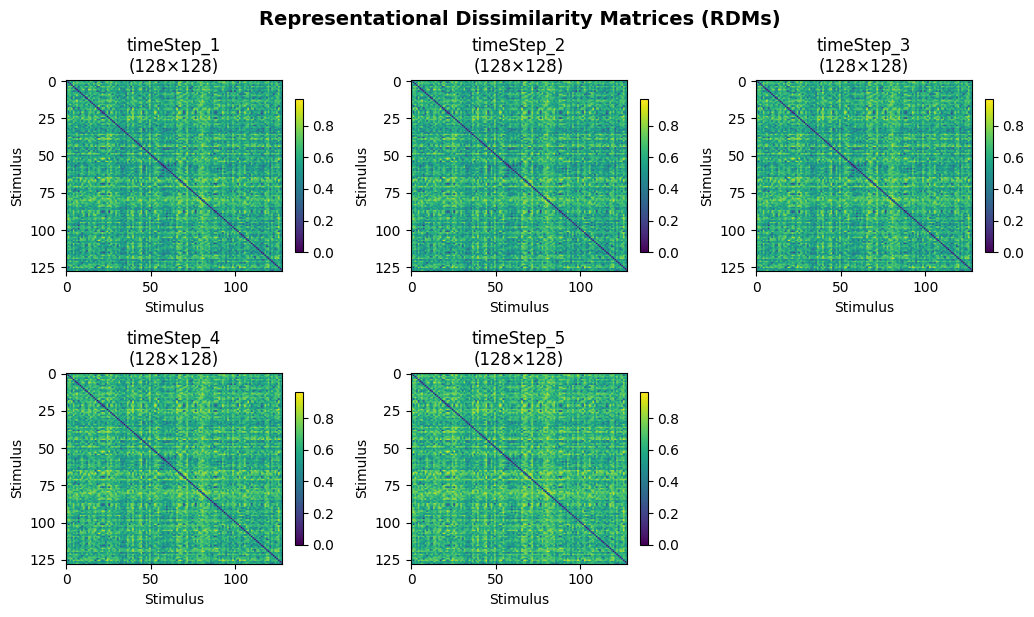

In [60]:
print(mem_stack_hid[0].shape)

ts_mem_act_dict= {}
i=0
for timeStep in snn_mem_rdms_dict.keys():
    ts_mem_act_dict[timeStep]= mem_stack_hid[i]
    i+= 1
    if i >= num_steps:
        break

print(ts_mem_act_dict.keys())
print('        --> timeStep 1: ', ts_mem_act_dict['timeStep_1'].shape)

# from pranati's code: 
rdms, rdms_dict = calc_rdms(ts_mem_act_dict, method='correlation')
plot_rdms(rdms_dict)



## Model Comparison and Statistical Inference

In [11]:
# fc1_rdm = snn_spk_rdms_dict['timeStep_1']
# plt.figure(figsize=(6,5))
# sns.heatmap(fc1_rdm, cmap='viridis')
# plt.title("RDM – timeStep1 Layer")
# plt.xlabel("Stimuli")
# plt.ylabel("Stimuli")
# plt.show()